<a href="https://colab.research.google.com/github/matildecanete/Proyecto-Ventas-Semanales-Walmart/blob/main/Ventas_Semanales_Walmart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data Science /Dataset/Walmart Dataset/archive.zip')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
df.shape

(6435, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [ ]:
df.isna().sum()

,0
Store,0
Date,0
Weekly_Sales,0
Holiday_Flag,0
Temperature,0
Fuel_Price,0
CPI,0
Unemployment,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,6435.0,2.300000e+01,12.988182,1.000,12.000,23.000000,3.400000e+01,4.500000e+01
Weekly_Sales,6435.0,1.046965e+06,564366.622054,209986.250,553350.105,960746.040000,1.420159e+06,3.818686e+06
Holiday_Flag,6435.0,6.993007e-02,0.255049,0.000,0.000,0.000000,0.000000e+00,1.000000e+00
Temperature,6435.0,6.066378e+01,18.444933,-2.060,47.460,62.670000,7.494000e+01,1.001400e+02
Fuel_Price,6435.0,3.358607e+00,0.459020,2.472,2.933,3.445000,3.735000e+00,4.468000e+00
CPI,6435.0,1.715784e+02,39.356712,126.064,131.735,182.616521,2.127433e+02,2.272328e+02
Unemployment,6435.0,7.999151e+00,1.875885,3.879,6.891,7.874000,8.622000e+00,1.431300e+01


Variable Store:

  - Las tiendas están enumeradas del 1 al 45.

Variable Ventas Semanales:

  - El promedio de las ventas semanales es 1,045,965 unidades.

  - La venta semanal más baja fue de 209,986 unidades.

  - La venta semanal más alta fue de 3,818,686 unidades.

  - La desviación estándar es de 564,366, lo que indica que la dispersión de las ventas representa más de la mitad del promedio. Esto significa que las ventas semanales pueden variar considerablemente respecto al valor medio, tanto hacia arriba como hacia abajo.

Variable Feriados:

  - En promedio, el 7% de las semanas corresponden a semanas con feriados.

Variable Desempleados:

  - En promedio, el 8% de la población se encontraba desempleada durante las semanas analizadas.

In [ ]:
#Columna 'Date'
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

df['Day'] = df['Date'].dt.day #Día del mes (1-31)
df['Day_name'] = df['Date'].dt.day_name() #Lunes, Martes, etc.
df['Day_week'] = df['Date'].dt.dayofweek #Lunes=0, Domingo=6
df['Month'] = df['Date'].dt.month #Mes (1-12)
df['Month_name'] = df['Date'].dt.month_name() #Enero, Febrero, etc.
df['Year'] = df['Date'].dt.year #Año
df['Week'] = df['Date'].dt.isocalendar().week #Semana del año (1-52)

In [ ]:
#Nueva columna 'Season'
df['Season'] = df['Month'].apply(lambda x: 'Winter' if x in [12, 1, 2]
                                else 'Spring' if x in [3, 4, 5]
                                else 'Summer' if x in [6, 7, 8]
                                else 'Fall')

In [ ]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Day_name,Day_week,Month,Month_name,Year,Week,Season
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,5,Friday,4,2,February,2010,5,Winter
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,12,Friday,4,2,February,2010,6,Winter
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,19,Friday,4,2,February,2010,7,Winter
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,26,Friday,4,2,February,2010,8,Winter
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,5,Friday,4,3,March,2010,9,Spring


In [ ]:
print(df['Store'].nunique())
print(df['Holiday_Flag'].value_counts())
print(df['Day'].nunique())
print(df['Day_name'].value_counts())
print(df['Day_week'].value_counts())
print(df['Month_name'].value_counts())
print(df['Year'].value_counts())
print(df['Week'].nunique())
print(df['Season'].value_counts())

45
Holiday_Flag
0    5985
1     450
Name: count, dtype: int64
31
Day_name
Friday    6435
Name: count, dtype: int64
Day_week
4    6435
Name: count, dtype: int64
Month_name
April        630
July         630
June         585
March        585
October      585
September    585
August       585
February     540
May          540
December     450
November     360
January      360
Name: count, dtype: int64
Year
2011    2340
2010    2160
2012    1935
Name: count, dtype: int64
52
Season
Summer    1800
Spring    1755
Fall      1530
Winter    1350
Name: count, dtype: int64


In [ ]:
print(df['Day_name'].value_counts())

Day_name
Friday    6435
Name: count, dtype: int64


>Los valores son coherentes e indican que los datos solo están registrados para los días viernes y, por lo tanto, no hay información de los otros días de la semana.

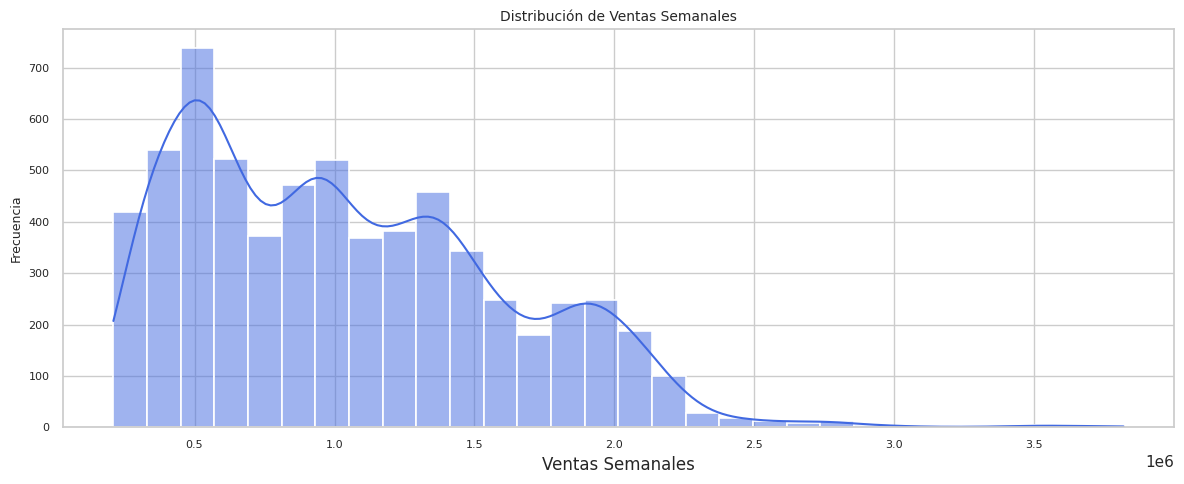

In [ ]:
#Distribución de Ventas Semanales
sns.set(style='whitegrid')

plt.figure(figsize=(12, 5))
sns.histplot(df['Weekly_Sales'], kde=True, color='#4169E1', bins=30, edgecolor='white', linewidth=1.2)
plt.title('Distribución de Ventas Semanales', fontsize=10)
plt.xlabel('Ventas Semanales', fontsize=12)
plt.ylabel('Frecuencia', fontsize=9)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

>Se puede observar que hay más semanas con ventas bajas y que las semanas con ventas altas son menos frecuentes.

In [ ]:
df['Year'].value_counts().sort_index()

,count
Year,
2010,2160
2011,2340
2012,1935


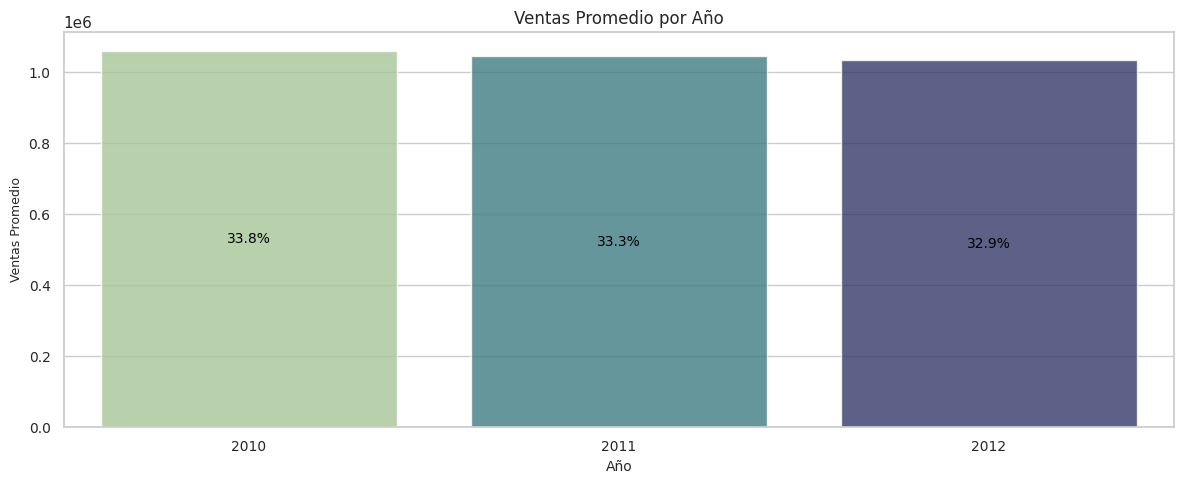

In [ ]:
#Ventas Promedio por Año
year_sales = df.groupby('Year')['Weekly_Sales'].mean().reset_index()

#Cálculo del porcentaje de cada barra respecto al total
total_sales = year_sales['Weekly_Sales'].sum()
year_sales['Percentage'] = (year_sales['Weekly_Sales'] / total_sales * 100).round(1)

plt.figure(figsize=(12, 5))
bars = sns.barplot(data=year_sales, x='Year', y='Weekly_Sales', hue='Year', palette='crest', legend=False, alpha=0.8)

for bar, percentage in zip(bars.patches, year_sales['Percentage']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height * 0.5, f'{percentage}%',
             ha='center', va='center', color='black', fontsize=10)

plt.title('Ventas Promedio por Año', fontsize=12)
plt.xlabel('Año', fontsize=10)
plt.ylabel('Ventas Promedio', fontsize=9)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

>Las ventas se muestran bastante parejas durante estos tres años, sin embargo, el año 2010 presenta el mayor promedio de ventas.

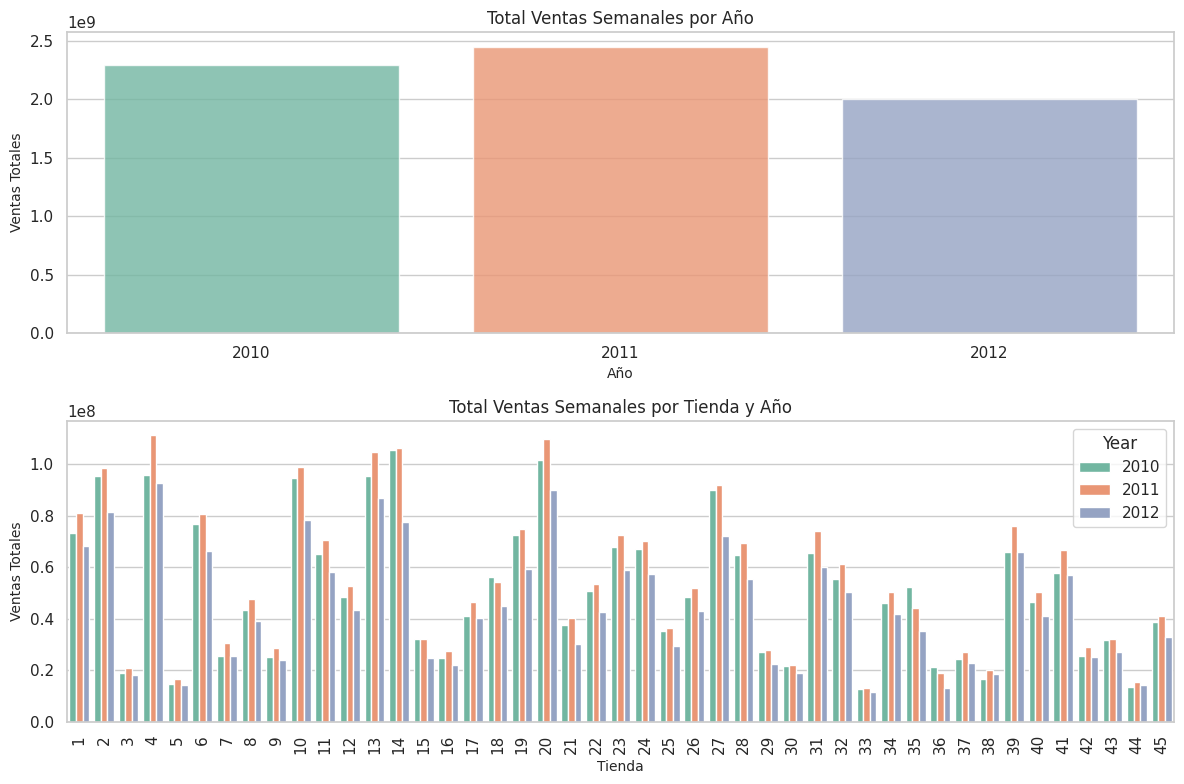

In [ ]:
#Total Ventas Semanales por Año
yearly_sales = df.groupby('Year')['Weekly_Sales'].sum().reset_index()

#Total Ventas Semanales por Tienda y Año
store_sales = df.groupby(['Store', 'Year'])['Weekly_Sales'].sum().reset_index()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
#Gráfico Total Ventas Semanales por Año
sns.barplot(data=yearly_sales, x='Year', y='Weekly_Sales', hue='Year', palette='Set2', legend=False, alpha=0.8, ax=axes[0])
axes[0].set_title('Total Ventas Semanales por Año', fontsize=12)
axes[0].set_xlabel('Año', fontsize=10)
axes[0].set_ylabel('Ventas Totales', fontsize=10)
#Gráfico Total Ventas Semanales por Tienda y Año
sns.barplot(data=store_sales, x='Store', y='Weekly_Sales', hue='Year', palette='Set2', ax=axes[1])
axes[1].set_title('Total Ventas Semanales por Tienda y Año', fontsize=12)
axes[1].set_xlabel('Tienda', fontsize=10)
axes[1].set_ylabel('Ventas Totales', fontsize=10)
axes[1].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

>El año 2011 registra el mayor volumen de ventas en comparación con 2010 y 2012. Además, se observa que, para la mayoría de las tiendas, las ventas de 2011 presentan las cifras más altas.

In [ ]:
print(df['Week'].describe())

count       6435.0
mean     25.818182
std      14.129201
min            1.0
25%           14.0
50%           26.0
75%           38.0
max           52.0
Name: Week, dtype: Float64


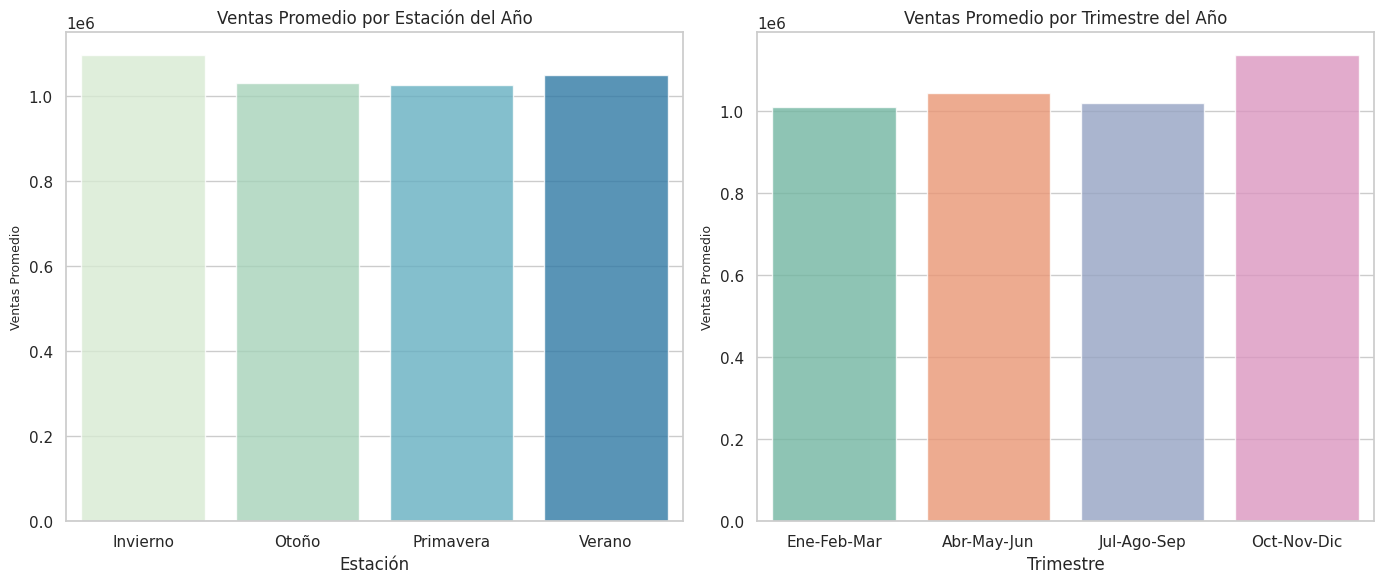

In [ ]:
#Nombres de estaciones
df['Season'] = df['Season'].map({
    'Spring': 'Primavera',
    'Summer': 'Verano',
    'Fall': 'Otoño',
    'Winter': 'Invierno'})

#Agrupación Ventas Semanales Promedio por Estación del Año
season_sales = df.groupby('Season')['Weekly_Sales'].mean().reset_index()

#Agrupación por trimestres
df['Week_Group'] = pd.cut(df['Week'], bins=[0, 13, 26, 39, 52], labels=['Q1', 'Q2', 'Q3', 'Q4']) #Orden del año dividido en trimestres
#Agrupación Ventas Semanales por Trimestre del Año
weekly_group_avg = df.groupby('Week_Group', observed=False)['Weekly_Sales'].mean().reset_index()
#Abreviaturas de los meses
weekly_group_avg['Month_Label'] = weekly_group_avg['Week_Group'].map({
    'Q1': 'Ene-Feb-Mar',
    'Q2': 'Abr-May-Jun',
    'Q3': 'Jul-Ago-Sep',
    'Q4': 'Oct-Nov-Dic'})

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
#Gráfico de estaciones
sns.barplot(data=season_sales, x='Season', y='Weekly_Sales', hue='Season', palette='GnBu', alpha=0.8, ax=axes[0])
axes[0].set_title('Ventas Promedio por Estación del Año', fontsize=12)
axes[0].set_xlabel('Estación', fontsize=12)
axes[0].set_ylabel('Ventas Promedio', fontsize=9)
axes[0].tick_params(axis='x', rotation=0)
#Gráfico de trimestres
sns.barplot(data=weekly_group_avg, x='Month_Label', y='Weekly_Sales', hue='Month_Label', palette='Set2', alpha=0.8, ax=axes[1])
axes[1].set_title('Ventas Promedio por Trimestre del Año', fontsize=12)
axes[1].set_xlabel('Trimestre', fontsize=12)
axes[1].set_ylabel('Ventas Promedio', fontsize=9)
plt.tight_layout()
plt.show()

>Las ventas promedio son más altas durante el invierno, en comparación con las demás estaciones.

>Las ventas promedio alcanzan su punto máximo en el cuarto trimestre del año.

In [ ]:
#Holiday Flag
print(df['Holiday_Flag'].value_counts())

Holiday_Flag
0    5985
1     450
Name: count, dtype: int64


In [ ]:
#Temperature
print(df['Temperature'].describe())

count    6435.000000
mean       60.663782
std        18.444933
min        -2.060000
25%        47.460000
50%        62.670000
75%        74.940000
max       100.140000
Name: Temperature, dtype: float64


In [ ]:
#Fuel_Price
print(df['Fuel_Price'].describe())

count    6435.000000
mean        3.358607
std         0.459020
min         2.472000
25%         2.933000
50%         3.445000
75%         3.735000
max         4.468000
Name: Fuel_Price, dtype: float64



Ventas promedio por feriados:
   Holiday_Flag  Weekly_Sales     Feriado
0             0  1.041256e+06  No Feriado
1             1  1.122888e+06     Feriado

Ventas promedio por categoría de temperatura:
  Temp_Category  Weekly_Sales
0          Baja  1.092913e+06
1    Media Baja  1.050486e+06
2    Media Alta  1.055020e+06
3          Alta  9.898828e+05

Ventas promedio por categoría de precio de combustible:
  Fuel_Category  Weekly_Sales
0          Bajo  1.035925e+06
1    Medio Bajo  1.065881e+06
2    Medio Alto  1.038736e+06
3          Alto  1.047799e+06


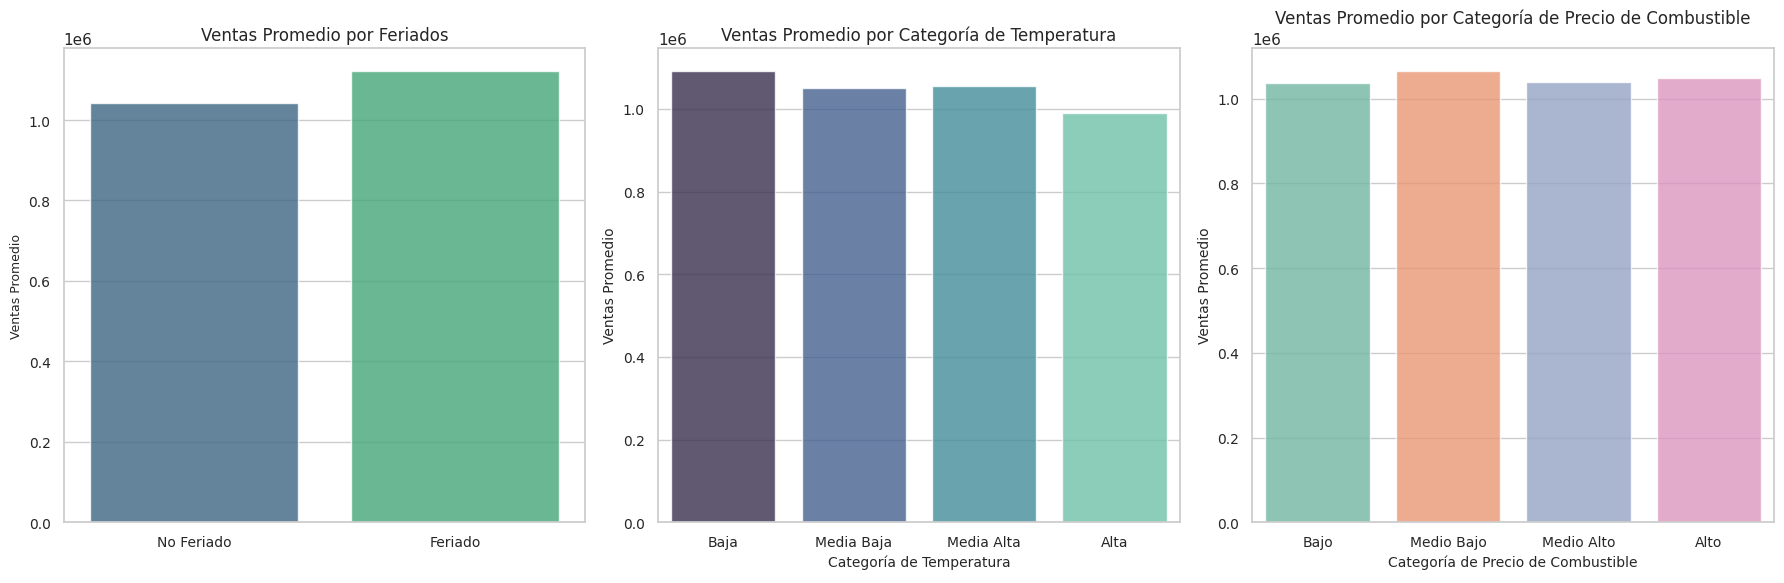

In [ ]:
#Gráficos Holiday Flag, Temperature y Fuel_Price

#Categorías Temperatura
temp_bins = [-2.06, 47.46, 62.67, 74.94, 100.14]
temp_labels = ['Baja', 'Media Baja', 'Media Alta', 'Alta']
df['Temp_Category'] = pd.cut(df['Temperature'], bins=temp_bins, labels=temp_labels, right=False)

#Categorías Combustible
fuel_bins = [2.47, 2.93, 3.44, 3.73, 4.46]
fuel_labels = ['Bajo', 'Medio Bajo', 'Medio Alto', 'Alto']
df['Fuel_Category'] = pd.cut(df['Fuel_Price'], bins=fuel_bins, labels=fuel_labels, right=False)

#Ventas promedio por feriados
holiday_sales = df.groupby('Holiday_Flag')['Weekly_Sales'].mean().reset_index()
holiday_sales['Feriado'] = holiday_sales['Holiday_Flag'].map({0: 'No Feriado', 1: 'Feriado'})
print("\nVentas promedio por feriados:")
print(holiday_sales)

#Ventas promedio por categoría de temperatura
temp_sales = df.groupby('Temp_Category', observed=False)['Weekly_Sales'].mean().reset_index()
print("\nVentas promedio por categoría de temperatura:")
print(temp_sales)

#Ventas promedio por categoría de combustible
fuel_sales = df.groupby('Fuel_Category', observed=False)['Weekly_Sales'].mean().reset_index()
print("\nVentas promedio por categoría de precio de combustible:")
print(fuel_sales)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

#Gráfico de Ventas Promedio por Feriados
sns.barplot(data=holiday_sales, x='Feriado', y='Weekly_Sales', hue='Feriado', palette='viridis', alpha=0.8, legend=False, ax=axes[0])
axes[0].set_title('Ventas Promedio por Feriados', fontsize=12)
axes[0].set_xlabel(' ')
axes[0].set_ylabel('Ventas Promedio', fontsize=9)
axes[0].tick_params(axis='both', labelsize=10)
#Gráfico de Ventas Promedio por Categoría de Temperatura
sns.barplot(data=temp_sales, x='Temp_Category', y='Weekly_Sales', hue='Temp_Category', palette='mako', alpha=0.8, ax=axes[1])
axes[1].set_title('Ventas Promedio por Categoría de Temperatura', fontsize=12)
axes[1].set_xlabel('Categoría de Temperatura', fontsize=10)
axes[1].set_ylabel('Ventas Promedio', fontsize=10)
axes[1].tick_params(axis='both', labelsize=10)
#Gráfico de Ventas Promedio por Categoría de Combustible
sns.barplot(data=fuel_sales, x='Fuel_Category', y='Weekly_Sales', hue='Fuel_Category', palette='Set2', alpha=0.8, ax=axes[2])
axes[2].set_title('Ventas Promedio por Categoría de Precio de Combustible', fontsize=12)
axes[2].set_xlabel('Categoría de Precio de Combustible', fontsize=10)
axes[2].set_ylabel('Ventas Promedio', fontsize=10)
axes[2].tick_params(axis='both', labelsize=10)
plt.tight_layout()
plt.show()

>Las semanas con feriados presentan ventas promedio levemente más altas que las semanas sin feriados.

>Las ventas promedio son mayores cuando la temperatura es baja, lo cual coincide con el patrón observado de mayores ventas en invierno.

>Las ventas promedio son ligeramente más altas cuando el precio del combustible se encuentra en la categoría medio-bajo.

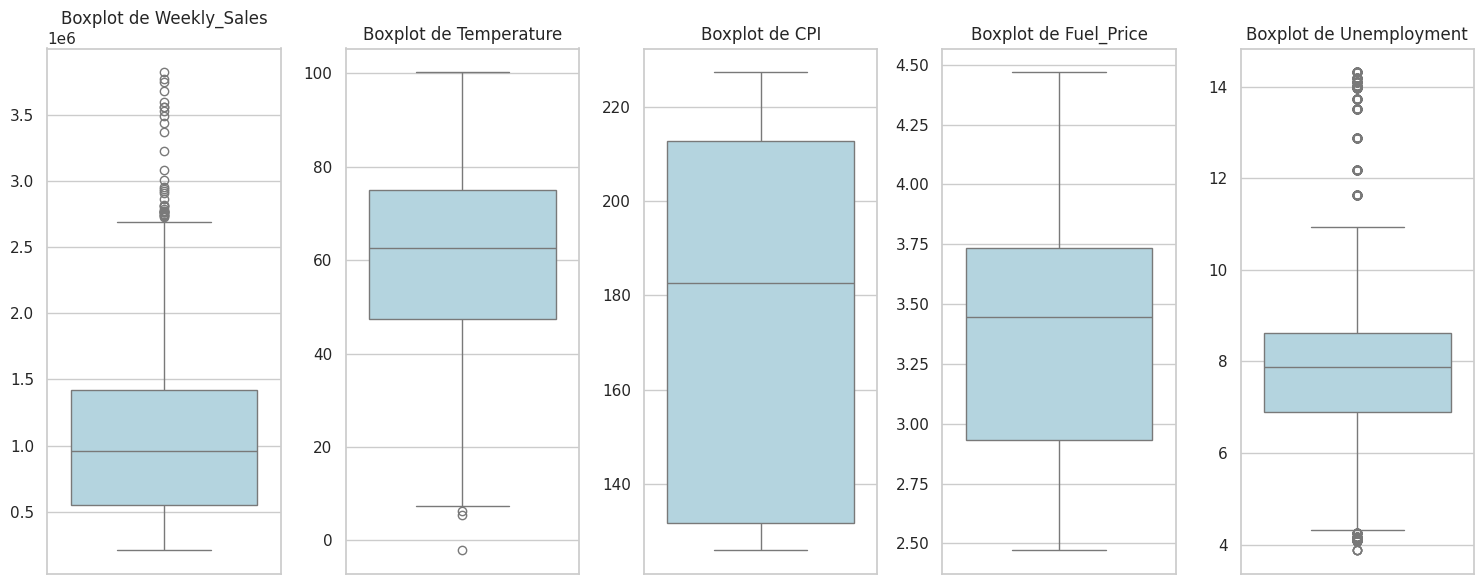

In [ ]:
#Boxplot
columns = ['Weekly_Sales', 'Temperature', 'CPI', 'Fuel_Price', 'Unemployment']

plt.figure(figsize=(15, 6))
for i, col in enumerate(columns, 1):
    plt.subplot(1, 5, i)
    sns.boxplot(data=df, y=col, color='lightblue')
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f'Boxplot de {col}')

plt.tight_layout()
plt.show()

>Hay presencia de outliers en Weekly_Sales, Temperature y Unemployment. Esto indica semanas con ventas muy altas, temperaturas inusuales y tasas de desempleo poco frecuentes.

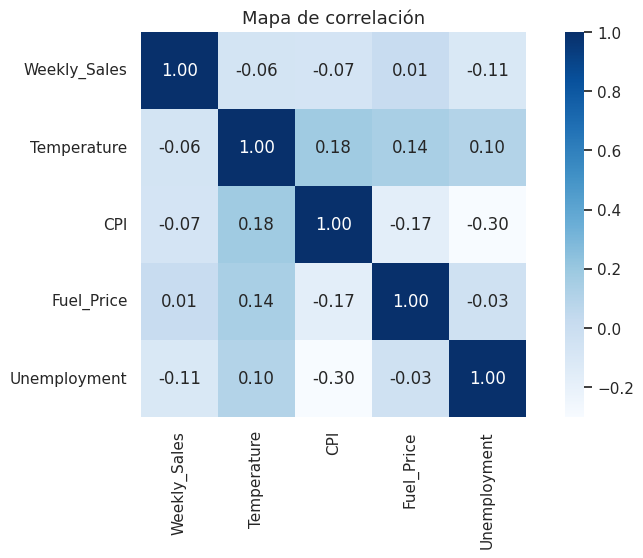

In [ ]:
columns = ['Weekly_Sales', 'Temperature', 'CPI', 'Fuel_Price', 'Unemployment']

correlation_data = df[columns].corr()

plt.figure(figsize=(10 , 5))
sns.heatmap(correlation_data, annot=True, square=True, cmap="Blues", fmt="0.2f")
plt.title("Mapa de correlación", fontsize=13)
plt.show()

>Se observa que las variables Temperature, CPI, Fuel_Price y Unemployment tienen correlaciones cercanas a cero con las ventas semanales, lo que indica que no existe una relación lineal entre estas características y la variable objetivo.

In [ ]:
#Se eliminan las columnas que no se utilizarán para los modelos predictivos
df.drop(columns=['Date', 'Day', 'Day_name', 'Day_week', 'Month_name', 'Season', 'Week', 'Week_Group', 'Temp_Category', 'Fuel_Category'], inplace=True)

In [ ]:
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,Year
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,2,2010
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,2,2010
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,2,2010
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,2,2010
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,3,2010


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
 7   Month         6435 non-null   int32  
 8   Year          6435 non-null   int32  
dtypes: float64(5), int32(2), int64(2)
memory usage: 402.3 KB


##Modelos Predictivos

In [ ]:
y = df['Weekly_Sales']
X = df.drop(columns= 'Weekly_Sales')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()

In [ ]:
num_selector = make_column_selector(dtype_include='number')

In [ ]:
num_tuple = (scaler, num_selector)

In [ ]:
col_transformer = make_column_transformer(num_tuple, remainder = 'passthrough')

In [ ]:
col_transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7e32a530ea50>)])

In [ ]:
X_train_processed = col_transformer.transform(X_train)
X_test_processed = col_transformer.transform(X_test)

In [ ]:
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)

All data in X_train_processed are float64
All data in X_test_processed are float64


###Decision Tree

In [ ]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_processed, y_train)

DecisionTreeRegressor(random_state=42)

###Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_processed, y_train)

RandomForestRegressor(random_state=42)

###Gradient Boosting

In [ ]:
gb = GradientBoostingRegressor(n_estimators=100)
gb.fit(X_train_processed, y_train)

GradientBoostingRegressor()

###XGBoost

In [ ]:
xgb = XGBRegressor(n_estimators=100)
xgb.fit(X_train_processed, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

##Métricas Modelos

In [ ]:
models = [dt, rf, gb, xgb]
model_names = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']
metrics_dict = {}

for model_name, model in zip(model_names, models):
    y_train_pred = model.predict(X_train_processed)
    y_test_pred = model.predict(X_test_processed)

    r2_train = r2_score(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    mae_train = mean_absolute_error(y_train, y_train_pred)

    r2_test = r2_score(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_test = mean_absolute_error(y_test, y_test_pred)

    r2_train_rounded = round(r2_train, 2)
    mse_train_rounded = round(mse_train, 2)
    rmse_train_rounded = round(rmse_train, 2)
    mae_train_rounded = round(mae_train, 2)

    r2_test_rounded = round(r2_test, 2)
    mse_test_rounded = round(mse_test, 2)
    rmse_test_rounded = round(rmse_test, 2)
    mae_test_rounded = round(mae_test, 2)

    metrics_df = pd.DataFrame({
        'Train': [r2_train_rounded, mae_train_rounded, mse_train_rounded, rmse_train_rounded],
        'Test': [r2_test_rounded, mae_test_rounded, mse_test_rounded, rmse_test_rounded]
    }, index=['R2', 'MAE', 'MSE', 'RMSE'])

    metrics_dict[model_name] = metrics_df

for model_name, metrics_df in metrics_dict.items():
    print(f"Métricas {model_name}")
    print(metrics_df.transpose())
    print("\n")

Métricas Decision Tree
         R2       MAE           MSE       RMSE
Train  1.00      0.00  0.000000e+00       0.00
Test   0.91  89480.51  2.923046e+10  170969.18


Métricas Random Forest
         R2       MAE           MSE       RMSE
Train  0.99  25938.00  2.450979e+09   49507.36
Test   0.94  72362.47  1.935901e+10  139136.67


Métricas Gradient Boosting
         R2        MAE           MSE       RMSE
Train  0.90  128690.73  3.132370e+10  176985.04
Test   0.89  133316.80  3.393227e+10  184207.15


Métricas XGBoost
         R2       MAE           MSE       RMSE
Train  0.99  29281.17  1.864846e+09   43183.86
Test   0.96  62748.90  1.278029e+10  113049.95




XGBoost se destaca como el modelo más eficaz para predecir las ventas semanales de Walmart.

Obtuvo el mayor valor de R² en el conjunto de prueba (0.96), lo que indica que fue el mejor en explicar las variaciones en las ventas reales a partir de las variables disponibles. Además, presentó el menor MAE y RMSE, lo que refleja que sus predicciones fueron, en promedio, más cercanas a los valores reales y con menos dispersión en los errores. En conclusión, predijo con mayor precisión y consistencia que los demás modelos.

